<a href="https://colab.research.google.com/github/nlei1/nlp-notebooks/blob/main/reddit_finetuned_biowordvec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np, pandas as pd 
import os
import zipfile
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
import gensim
import gensim.downloader as api
from gensim.models import Word2Vec 
import seaborn as sns
import matplotlib.pyplot as pyplot
%matplotlib inline

In [16]:
from nltk.tokenize import RegexpTokenizer

In [2]:
!wget -P /root/input/ -c 'https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin'

--2022-06-28 19:26:21--  https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.10, 130.14.250.12, 2607:f220:41e:250::10, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13451441787 (13G) [application/octet-stream]
Saving to: ‘/root/input/BioWordVec_PubMed_MIMICIII_d200.vec.bin’

BioWordVec_PubMed_M 100%[===================>]  12.53G   100MB/s    in 6m 1s   

2022-06-28 19:32:22 (35.6 MB/s) - ‘/root/input/BioWordVec_PubMed_MIMICIII_d200.vec.bin’ saved [13451441787/13451441787]



In [3]:
import gensim
# https://github.com/ncbi-nlp/BioSentVec
# Embeddings using PubMed and the clinical notes from MIMIC-III Clinical Database

model = gensim.models.KeyedVectors.load_word2vec_format(
     '/root/input/BioWordVec_PubMed_MIMICIII_d200.vec.bin',
      binary=True,
      limit=int(4E6)
)

In [13]:
url1 = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/noi.csv'
drugs = pd.read_csv(url1, error_bad_lines=False)
url2 = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/data.csv'
df = pd.read_csv(url2, error_bad_lines=False)
url3 = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/reddit_entries2.csv'
forum_posts = pd.read_csv(url3, error_bad_lines=False, names=["Message"])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [14]:
forum_posts

,Message
0,"i'm in so much pain, i wish my insomnia could ..."
1,Insomnia caused by my dreams??? Anyone know wh...
2,Woken up immediately after falling asleep
3,just complaining
4,Strange joint pain and discomfort?
...,...
31331,Happy new year!
31332,"Alcohol induced insomnia, even after taking me..."
31333,Insomnia feels so lonely.
31334,Insomnia affecting my relationship...what to do?


In [17]:
sentences = forum_posts.Message.astype('str').tolist()
tokenizer = RegexpTokenizer(r'\w+')
sentences_tokenized = [w.lower() for w in sentences]
sentences_tokenized = [tokenizer.tokenize(i) for i in sentences_tokenized]

In [25]:
model_2 = Word2Vec(size=200, min_count=1)
model_2.build_vocab(sentences_tokenized)
total_examples = model_2.corpus_count


In [26]:
model_2.intersect_word2vec_format('/root/input/BioWordVec_PubMed_MIMICIII_d200.vec.bin', binary=True)

In [27]:
model_2.train(sentences_tokenized, total_examples=total_examples, epochs=5)

(958180, 1326265)

In [29]:
url  = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/drugs-side-effects3.csv'
df = pd.read_csv(url, header=None, error_bad_lines=False)
ind_dct = {k: v for v, k in enumerate(df[0].tolist())}

def get_words(drug_name):
  return [incom for incom in df.iloc[ind_dct[drug_name]] if str(incom) != 'nan']

def get_embeddings(words_lst):
  # takes in a name and returns a lst of embeddings of drug and its related words
  embeddings = []
  for item in words_lst:
    embeddings.append(model[item])
  return embeddings

def get_pca(embeddings, n_components):
  pca = PCA(n_components)
  pca_result = pca.fit_transform(embeddings)
  post_pca = pd.DataFrame(pca_result, columns = ['x','y'])
  return post_pca

def get_tsne(embeddings, p_perplexity, p_n_iter, n_components):
  tsne = TSNE(n_components, perplexity=p_perplexity, n_iter=p_n_iter)
  tsne_result = tsne.fit_transform(embeddings)
  post_tsne = pd.DataFrame(tsne_result, columns = ['x','y'])
  return post_tsne

def plot_with_labels(drug_name, pca=True, p_perplexity=1, p_n_iter=1000, n_components=2):
  words_lst = get_words(drug_name)
  embeddings_lst = get_embeddings(words_lst)
  if pca:
    post_reduction = get_pca(embeddings_lst, n_components)
  else:
    post_reduction = get_tsne(embeddings_lst, p_perplexity, p_n_iter, n_components)
  post_reduction_annotated = post_reduction.join(pd.DataFrame(words_lst, columns=['label']))
  ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10))
  post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [31]:
for drug in ind_dct:
  print("\n\n" + drug + ":")
  print(model.most_similar(positive=[drug, 'sideeffects'], negative=['medication', 'name'], topn=10))

  # for drug X: how do we eliminate words with prefix of X? 



zolpidem:
[('flunitrazepam-induced', 0.4147284924983978), ('gaboxadol', 0.4077865481376648), ("gaboxadol's", 0.40618112683296204), ('flurazepam-induced', 0.4036608934402466), ('tazepam', 0.40044814348220825), ('flunitrazepam-', 0.3992939591407776), ('flunitrazepam', 0.39325523376464844), ('h-flunitrazepam', 0.39204108715057373), ('ketamine-flunitrazepam', 0.389299601316452), ('oxazepam-induced', 0.3892900347709656)]


eszopiclone:
[('gaboxadol', 0.43159541487693787), ("gaboxadol's", 0.4145936965942383), ('oxadol', 0.3878837525844574), ("eszopiclone's", 0.37662872672080994), ('azd-r', 0.3633575141429901), ('zopiclon', 0.3593076467514038), ('ezg/rtg', 0.3587183952331543), ('flurazepam-induced', 0.35748201608657837), ('fosazepam', 0.3546885550022125), ('tazepam', 0.3532983064651489)]


zaleplon:
[('gaboxadol', 0.3957788348197937), ("gaboxadol's", 0.39570152759552), ('flunitrazepam-induced', 0.3734953999519348), ('tazepam', 0.36946526169776917), ('flurazepam-induced', 0.3692311644554138)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


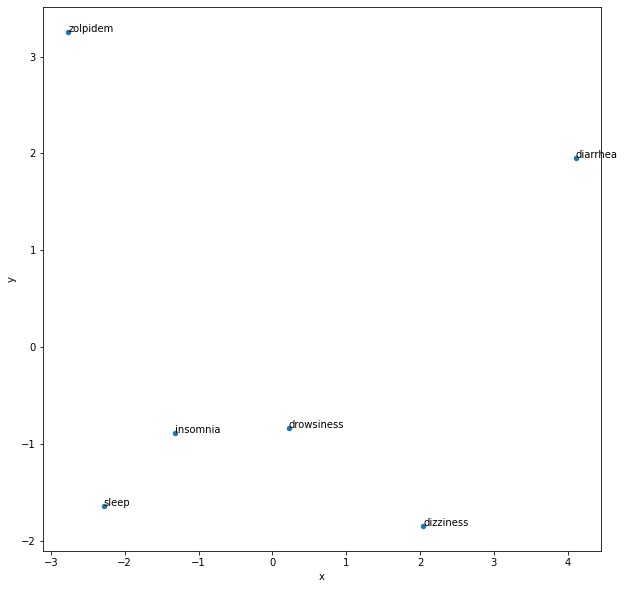

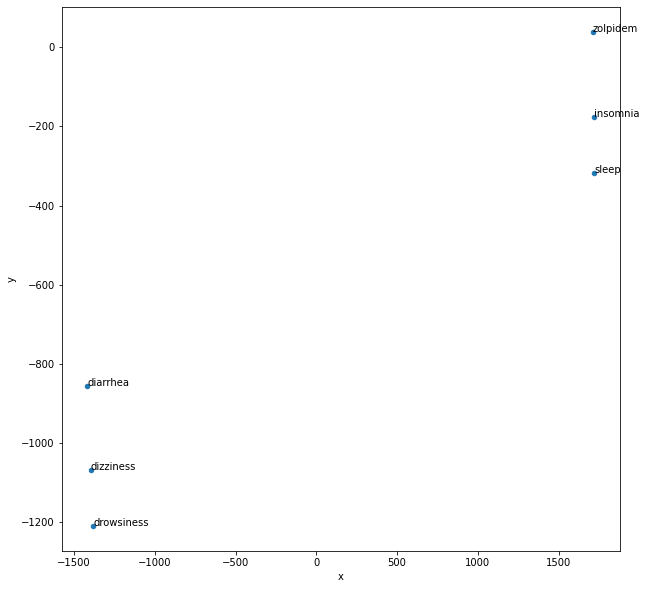

In [30]:
plot_with_labels('zolpidem')
plot_with_labels('zolpidem', False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


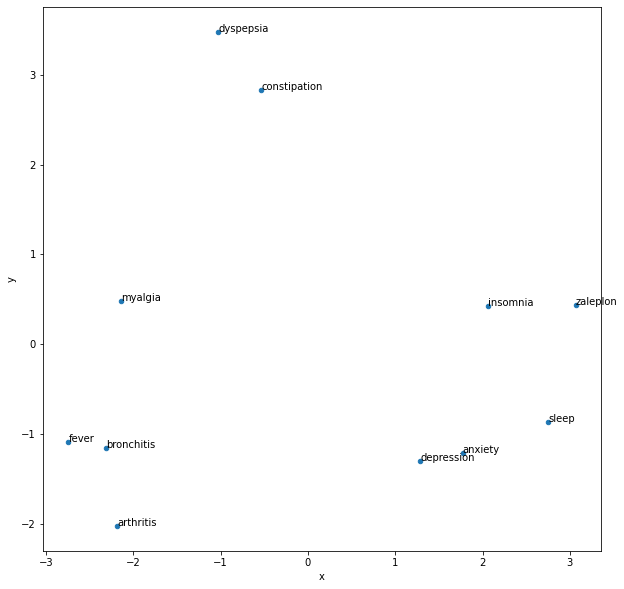

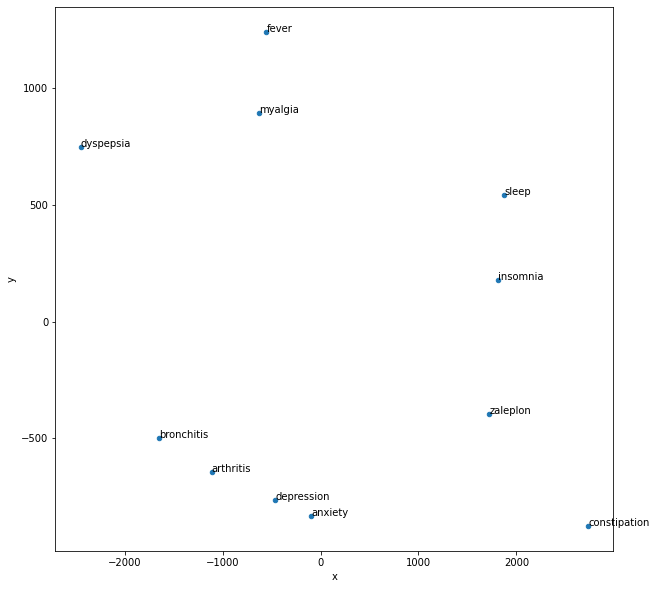

In [32]:
plot_with_labels('zaleplon')
plot_with_labels('zaleplon', False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


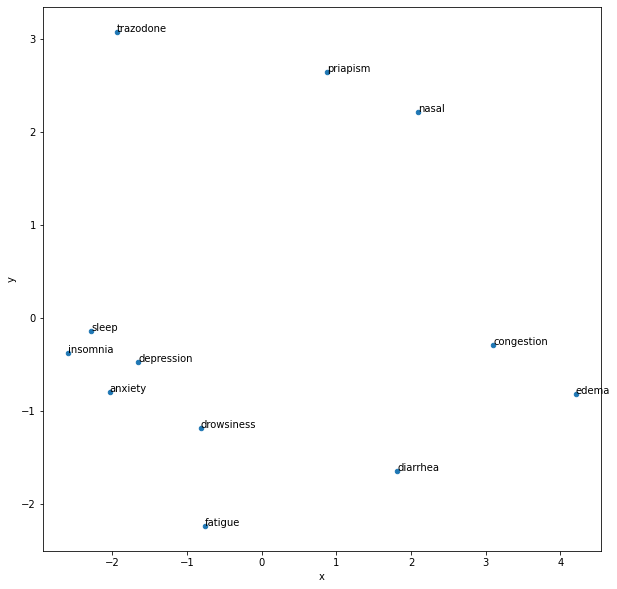

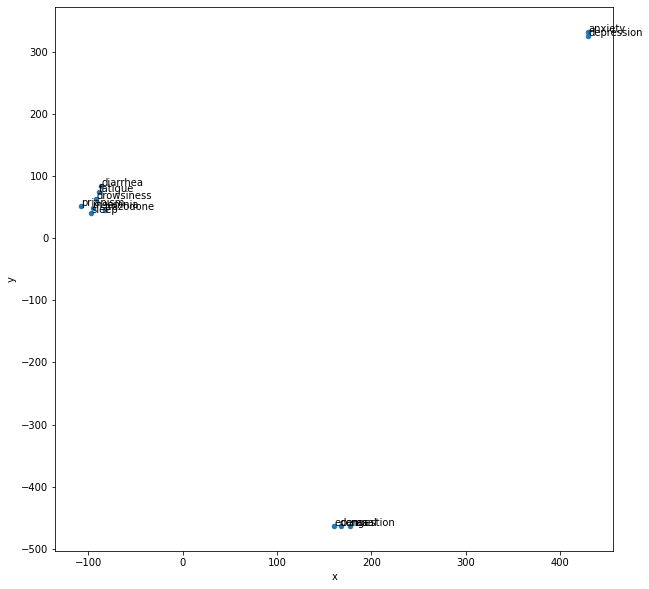

In [33]:
plot_with_labels('trazodone')
plot_with_labels('trazodone', False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


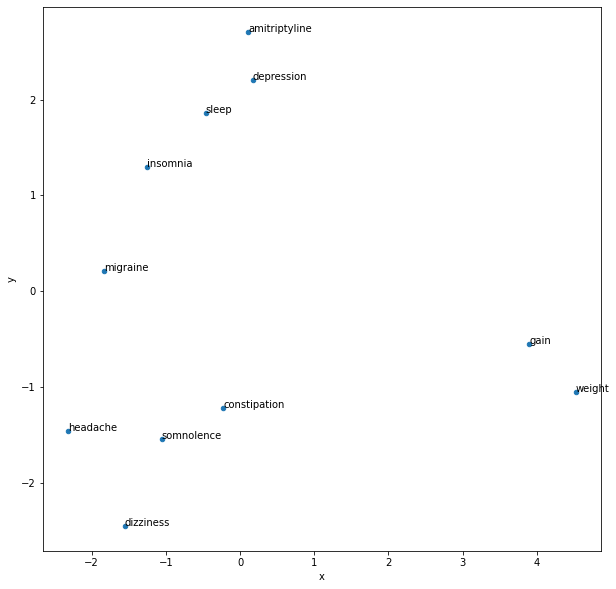

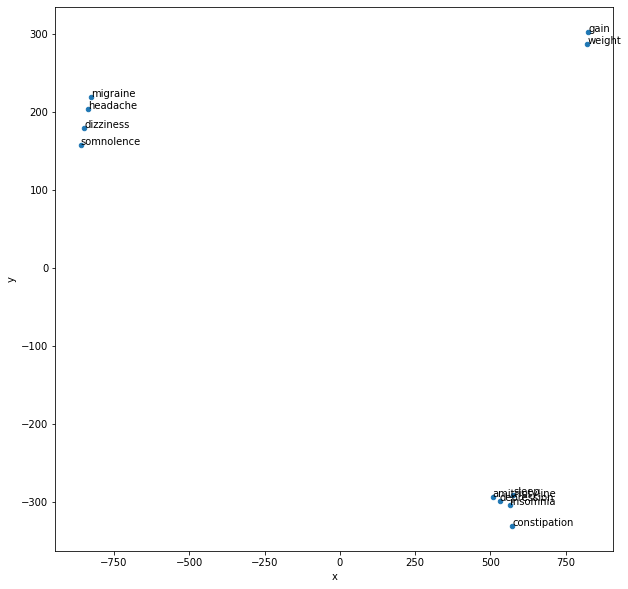

In [34]:
plot_with_labels('amitriptyline')
plot_with_labels('amitriptyline', False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


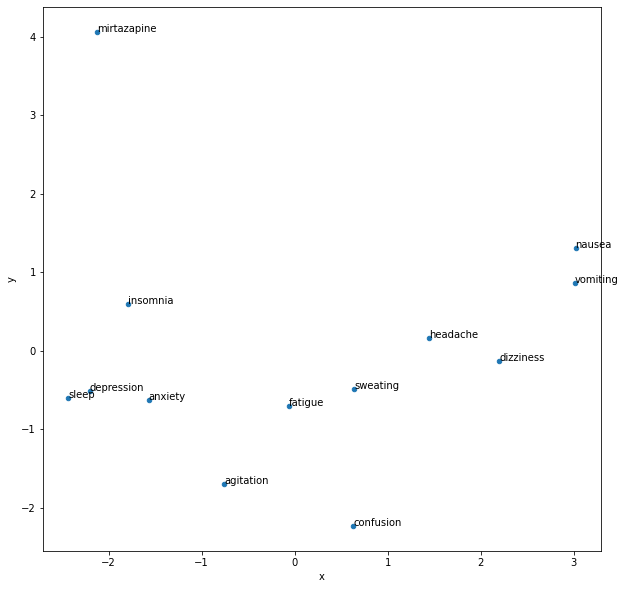

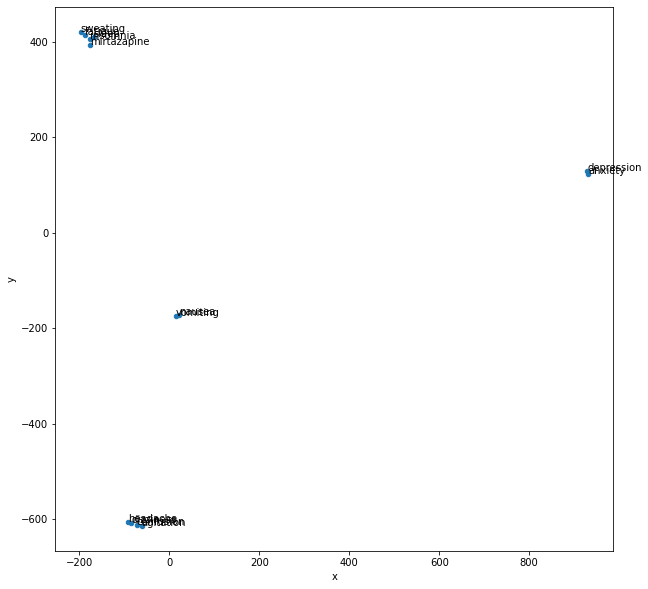

In [35]:
plot_with_labels('mirtazapine')
plot_with_labels('mirtazapine', False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


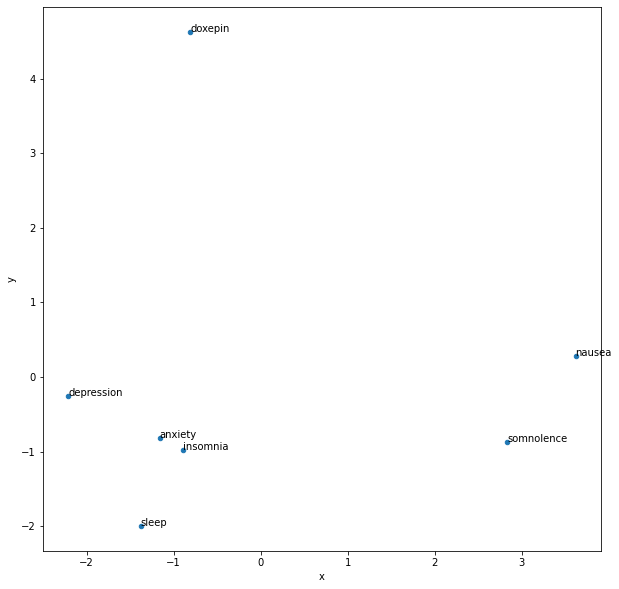

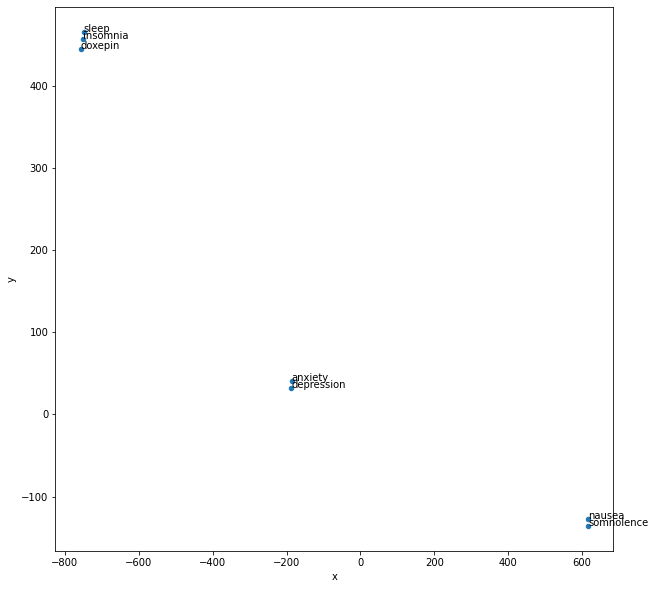

In [36]:
plot_with_labels('doxepin')
plot_with_labels('doxepin', False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


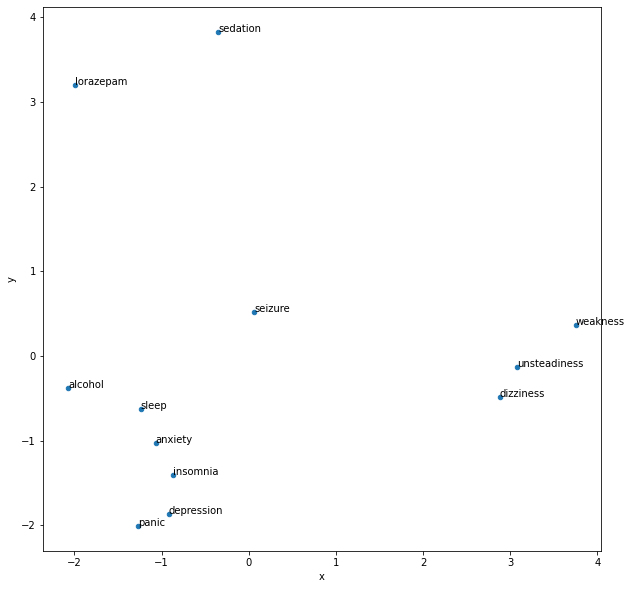

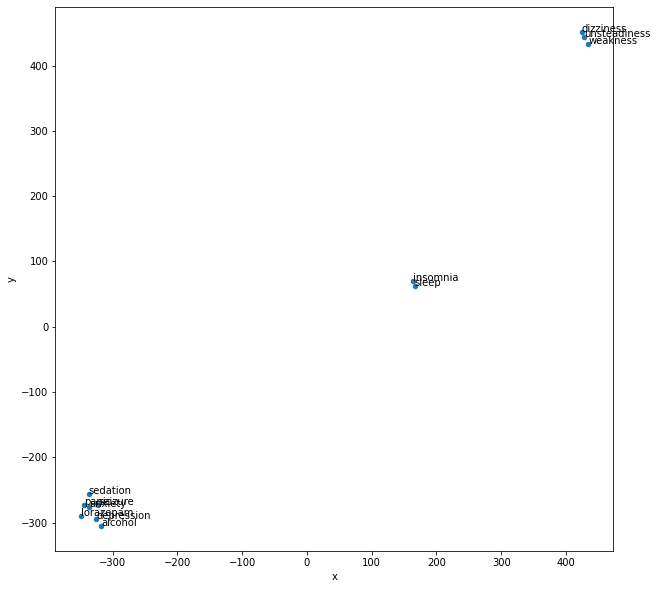

In [37]:
plot_with_labels('lorazepam')
plot_with_labels('lorazepam', False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


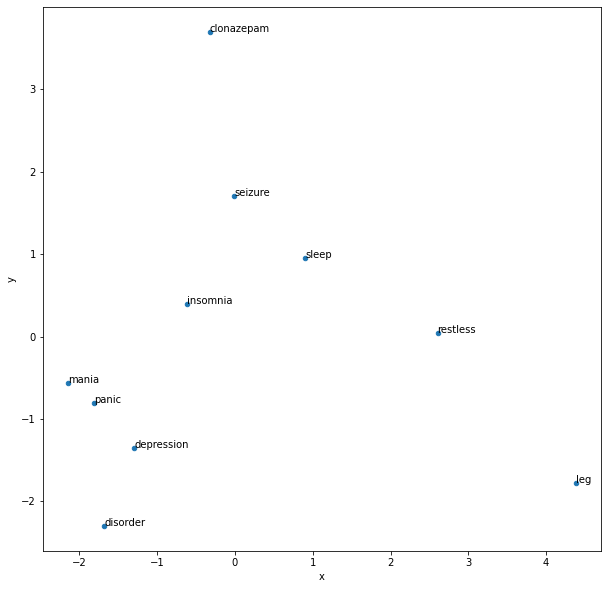

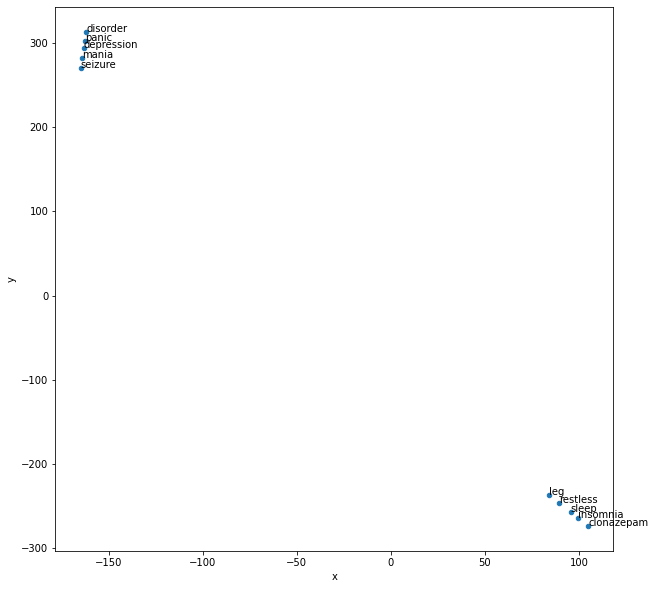

In [38]:
plot_with_labels('clonazepam')
plot_with_labels('clonazepam', False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


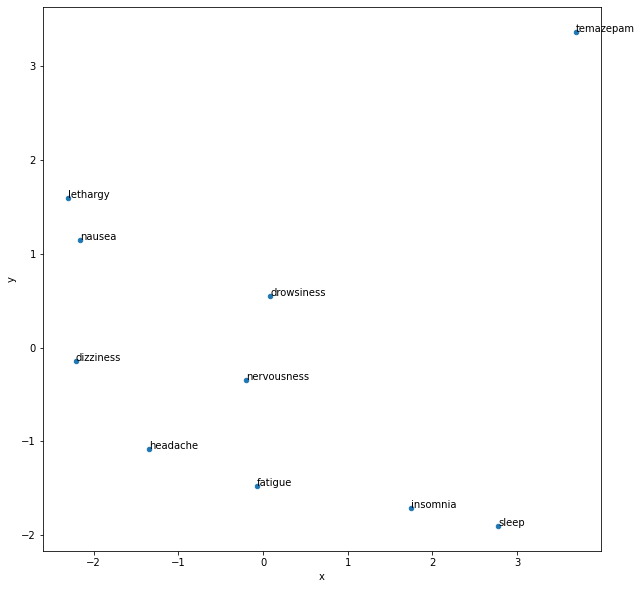

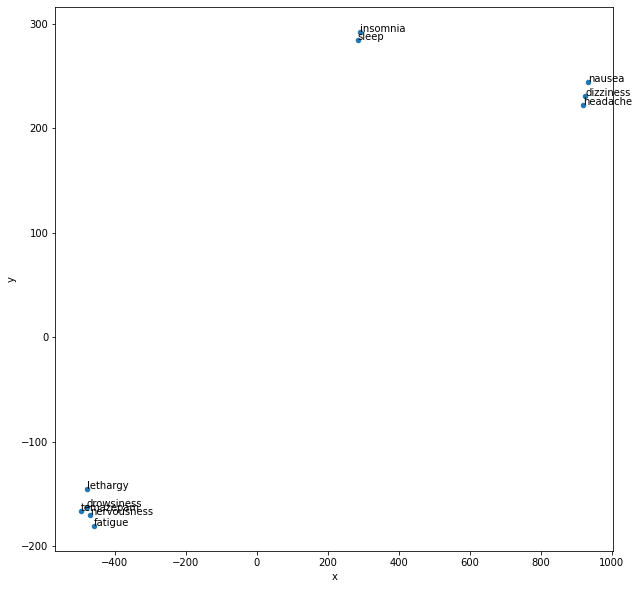

In [39]:
plot_with_labels('temazepam')
plot_with_labels('temazepam', False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


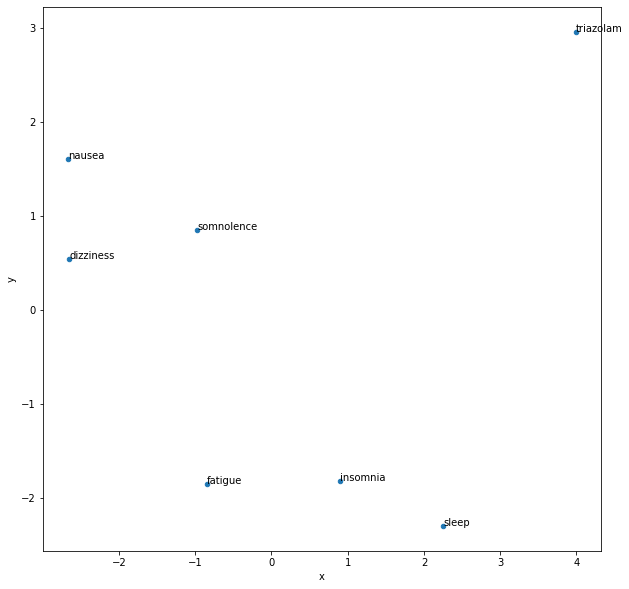

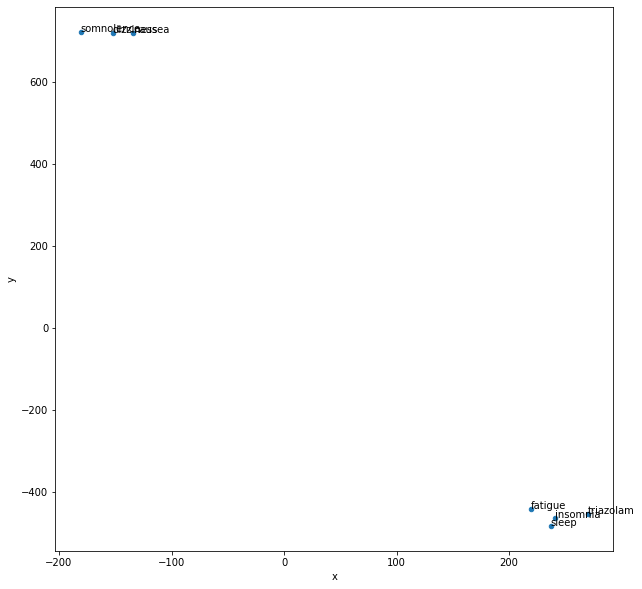

In [40]:
plot_with_labels('triazolam')
plot_with_labels('triazolam', False)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


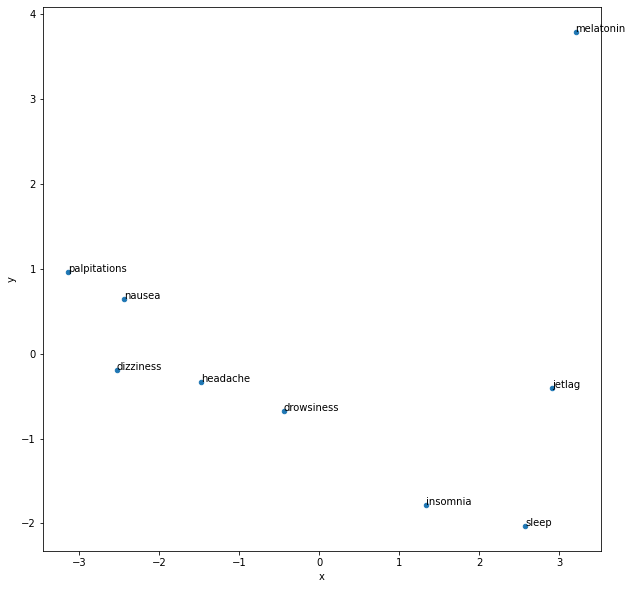

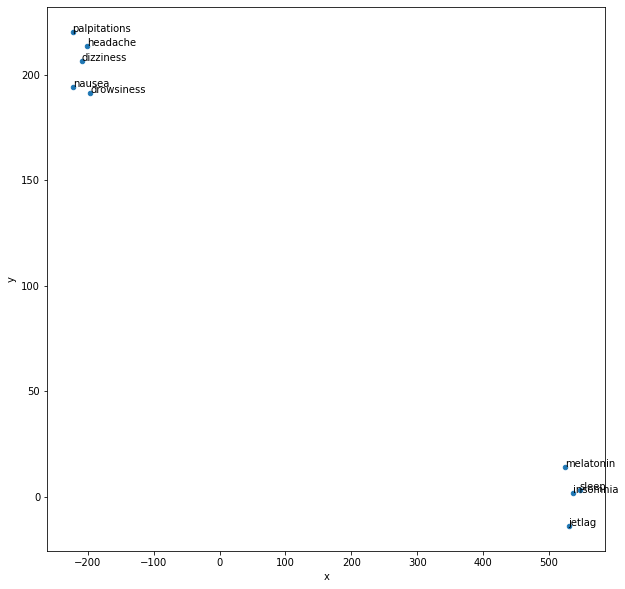

In [41]:
plot_with_labels('melatonin')
plot_with_labels('melatonin', False)

0     Text(-2.125305599676706, -0.021582376739308094...
1     Text(-1.3618271753290463, 0.5883204736175811, ...
2     Text(-2.0427269983823653, 1.0108660645496474, ...
3     Text(-1.3895076099861319, -0.655327142414519, ...
4     Text(-0.49365997203242806, -0.4915797600830818...
5     Text(-1.0822071507006497, -0.8520175875189886,...
6     Text(-1.0107045483272832, -0.35561553362141907...
7     Text(-1.9706407126406478, -1.822172646426965, ...
8     Text(-1.8971521708116512, -0.805015388567089, ...
9     Text(-2.0384252721799427, -0.5815017141159743,...
10    Text(-2.200418059771709, 0.7998772966059886, '...
11    Text(0.08060623651156272, 4.381455669508034, '...
12    Text(3.6049490773954926, -0.8600556552468432, ...
13    Text(3.6049490773954926, -0.8600556552468432, ...
14    Text(3.513639020442423, 0.3476626083312874, 'f...
15    Text(3.289169440603401, 0.6678982389885691, 'l...
16    Text(3.519262417490187, -0.49115689162007714, ...
dtype: object

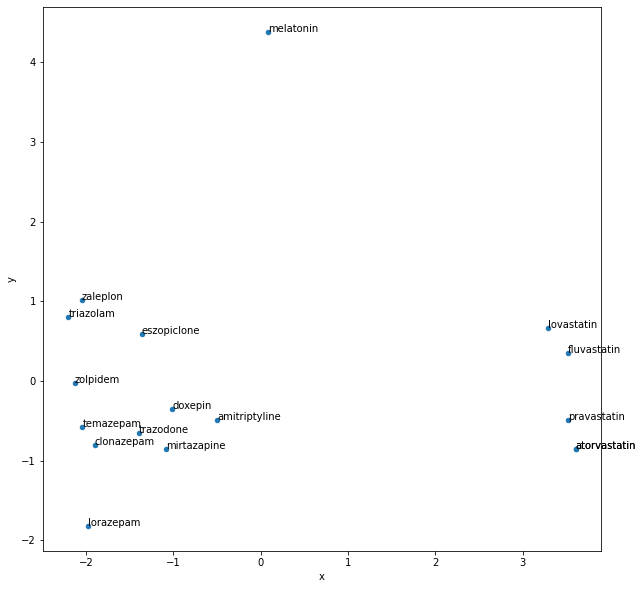

In [42]:
words_lst = df[0].tolist() + ['atorvastatin', 'fluvastatin', 'lovastatin', 'pravastatin']
embeddings_lst = get_embeddings(words_lst)
post_reduction = get_pca(embeddings_lst, n_components=2)
post_reduction_annotated = post_reduction.join(pd.DataFrame(words_lst, columns=['label']))
ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10))
post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


0     Text(-15.611352920532227, -126.4216079711914, ...
1     Text(-20.72928810119629, -139.90805053710938, ...
2     Text(-17.634580612182617, -131.74945068359375,...
3     Text(-188.02392578125, -583.4898681640625, 'tr...
4     Text(-485.29461669921875, 174.50579833984375, ...
5     Text(-182.51934814453125, -583.4905395507812, ...
6     Text(-480.5255126953125, 177.6455535888672, 'd...
7        Text(480.8125, -92.0018539428711, 'lorazepam')
8     Text(480.4580993652344, -86.29441833496094, 'c...
9     Text(481.4044494628906, -101.54190063476562, '...
10    Text(481.92938232421875, -109.97970581054688, ...
11    Text(-492.5730285644531, 169.71234130859375, '...
12    Text(-197.64405822753906, 91.86576080322266, '...
13    Text(-197.9772491455078, 97.37670135498047, 'a...
14    Text(7.59490442276001, 527.7694702148438, 'flu...
15    Text(16.315189361572266, 527.8436889648438, 'l...
16    Text(1.900449275970459, 527.7207641601562, 'pr...
dtype: object

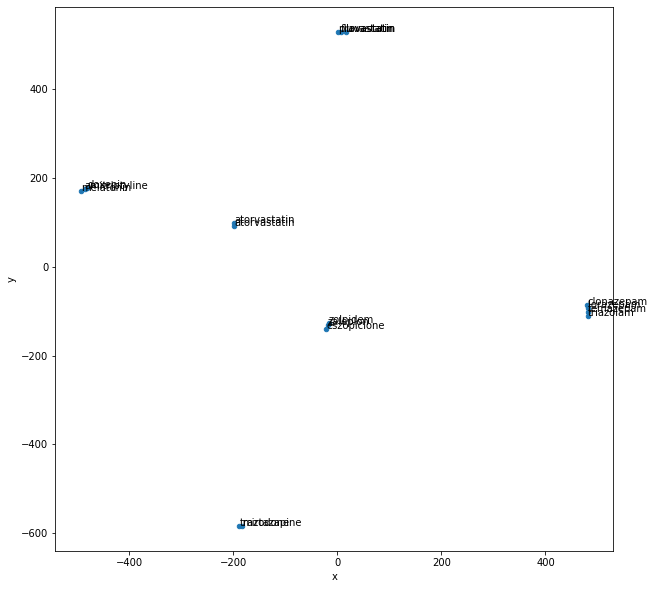

In [43]:
words_lst = df[0].tolist() + ['atorvastatin', 'fluvastatin', 'lovastatin', 'pravastatin']
embeddings_lst = get_embeddings(words_lst)
post_reduction = get_tsne(embeddings_lst, p_perplexity=1, p_n_iter=1000, n_components=2)
post_reduction_annotated = post_reduction.join(pd.DataFrame(words_lst, columns=['label']))
ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10))
post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)